<h1> Visualizing MPS compression </h1>

<p>
   This example demonstrates the effectiveness of using a matrix product state (MPS) to compress a high rank tensor even in the presence of long-range correlations. A 512x512 image is converted into a rank 18 tensor, which is subsequently compressed as a MPS. The conversion from 512x512 matrix to rank 18 tensor of index dimension 2 is completely naive-- for example, the original 512-dimension corresponding to the x-axis is split into two spaces of dimension 256, corresponding to the left and right halves of the image. Likewise for the y-axis: the image is split into two more spaces of dimension 256, corresponding to the top and bottom half. This process is repeated until each space is of dimension two (which is chosen since the total size of the image is $512^2=2^{18}$). The difference between original and compressed image over a range of
   bond dimensions is shown at the bottom. Of particular interest is the fact that using bond dimension 100,
   which results in a compression ratio of over 2.2, results in only a few small visible artifacts.
</p>

$$
    \text{Compression ratio} = \frac{\text{# floats in original}}{\text{# floats in MPS representation}}
$$

<p>
    To ensure zero loss requires a bond dimension of 512, at which point using MPS provides zero advantage, and in fact results in a compression ratio $<1$.
</p>

<p>
    It is worth postulating that fancier methods of converting the 512x512 image into a rank-18 tensor could lower the minimum bond dimension to ensure the abscence of visual artifacts.
    </p>

In [2]:
include("../mps.jl")
using .MatrixProductState
using LinearAlgebra
using Images

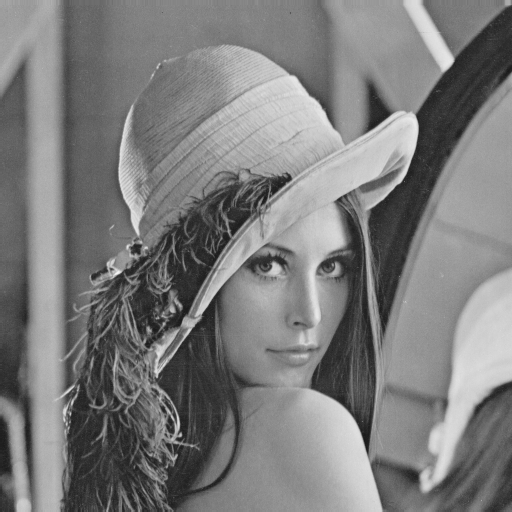

In [3]:
lenna = load("./lena512.bmp")

"Bond dimension - 2"

"total float count - 136"

"compression ratio - 1927.5294117647059"

"Resulting image"

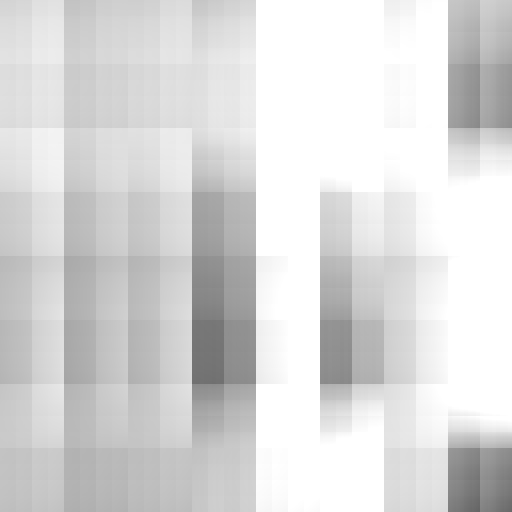

"Difference"

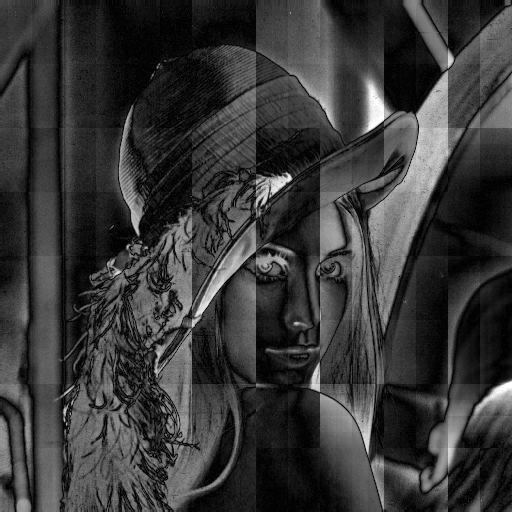

"Bond dimension - 4"

"total float count - 488"

"compression ratio - 537.1803278688525"

"Resulting image"

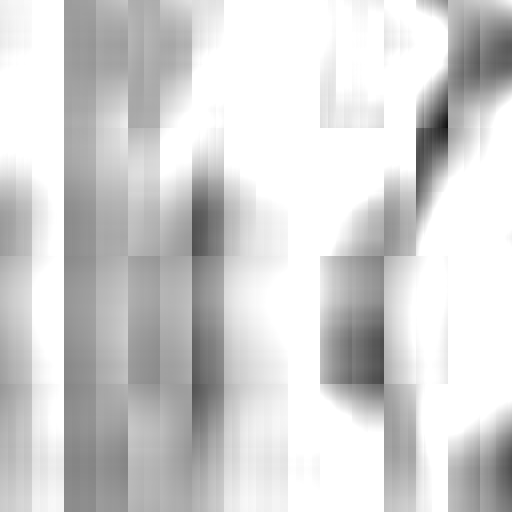

"Difference"

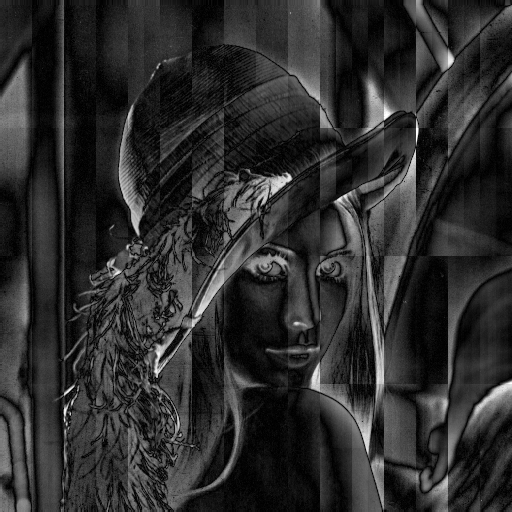

"Bond dimension - 9"

"total float count - 2076"

"compression ratio - 126.27360308285164"

"Resulting image"

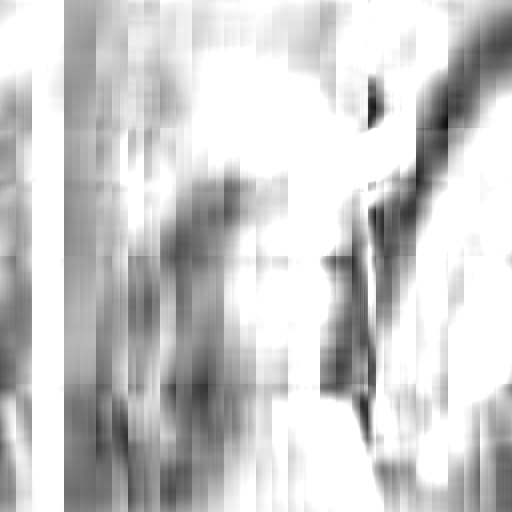

"Difference"

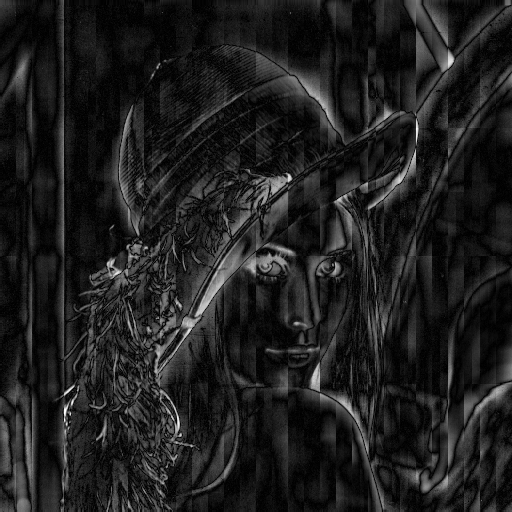

"Bond dimension - 18"

"total float count - 7016"

"compression ratio - 37.36374002280502"

"Resulting image"

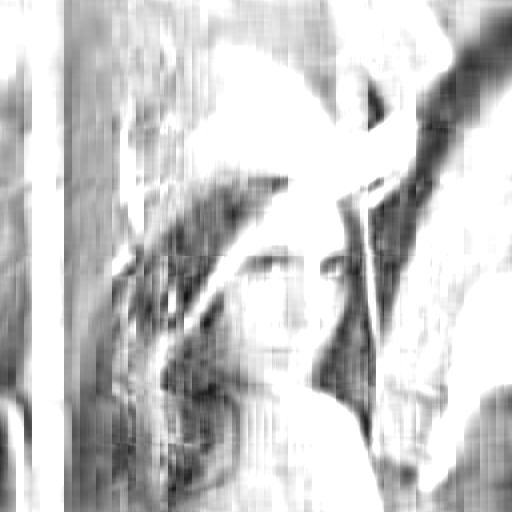

"Difference"

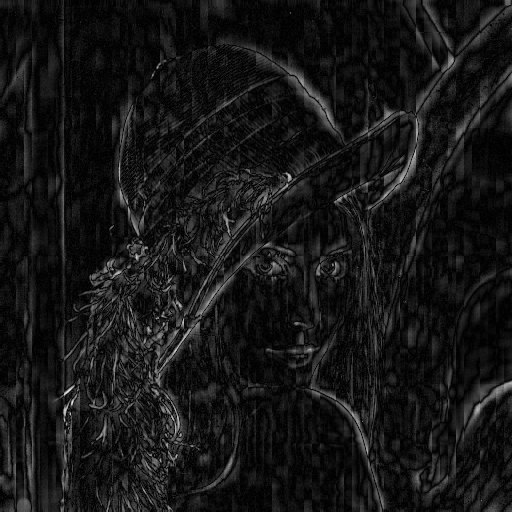

"Bond dimension - 20"

"total float count - 8360"

"compression ratio - 31.356937799043063"

"Resulting image"

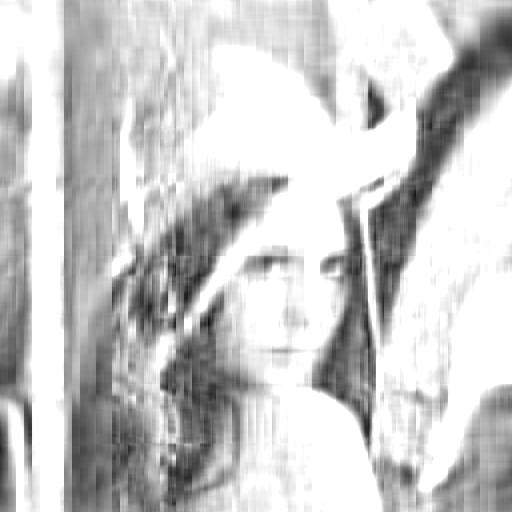

"Difference"

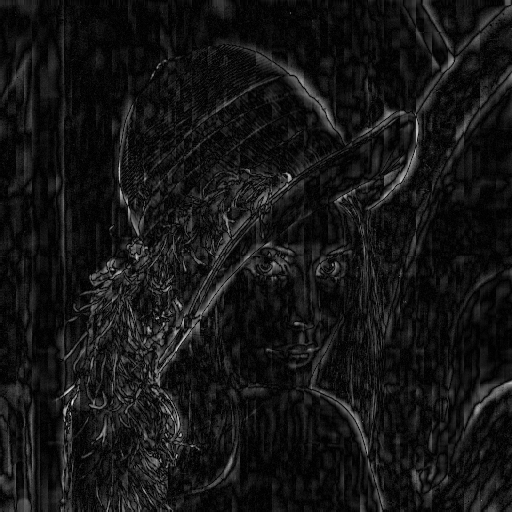

"Bond dimension - 100"

"total float count - 116520"

"compression ratio - 2.249776862341229"

"Resulting image"

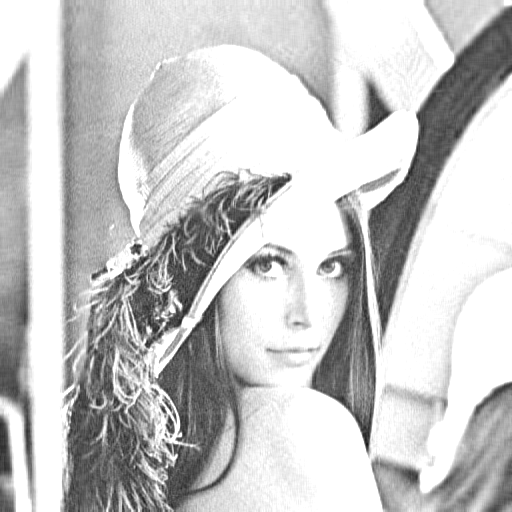

"Difference"

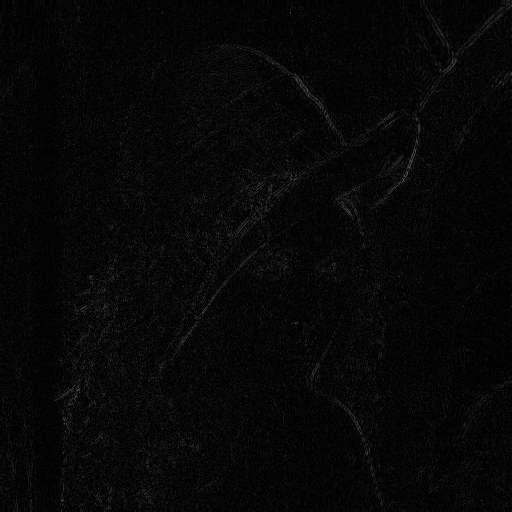

"Bond dimension - 512"

"total float count - 699048"

"compression ratio - 0.3750014305169316"

"Resulting image"

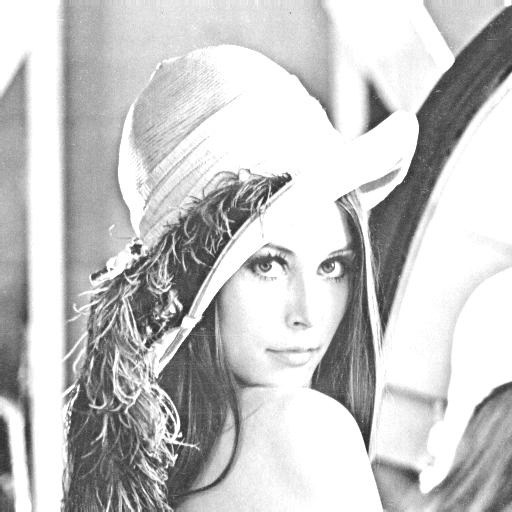

"Difference"

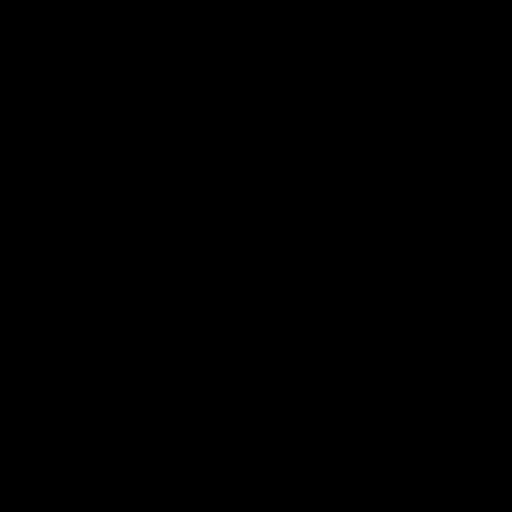

In [35]:
lenna_grayscale = map(x->norm([x.r, x.g, x.b]), lenna)

function mps_reduce_lenna(bond_dim)
    # Change 512x512 matrix into a 2x2x2x2x2x2x2x2x2x2x2x2x2x2x2x2x2x2 tensor
    lenna_tensor = reshape(lenna_grayscale, (2 for _=1:log2(512^2))...)
    # Get MPS representation of image tensor
    sites = MatrixProductState.mps(lenna_tensor, bond_dim)
    # Count total floats in image
    float_count = sum(length, sites)
    # Contract MPS tensor back into a matrix for visual comparison
    r=trunc(Int, log2(512^2))
    axis_dim = div(length(sites[2]), 2)
    intermediate = reshape(sites[2], axis_dim, 2) * sites[1]
    for i=2:r-2
        axis_dim = size(sites[i+1])[3]
        left_axis_dim = div(length(sites[i+1]), axis_dim)
        right_axis_dim = div(length(intermediate), axis_dim)
        intermediate = reshape(sites[i+1], left_axis_dim, axis_dim) *
            reshape(intermediate, axis_dim, right_axis_dim)
    end
    lenna_mps = sites[r] * reshape(intermediate, 2, 2^(r-1))
    lenna_mps = reshape(lenna_mps, 512, 512)
    lenna_mps_res = map(x->RGB(x,x,x), lenna_mps)
    lenna_mps_diff = map(x->RGB(x,x,x), abs.(lenna_mps - lenna_grayscale))
    return lenna_mps_res, lenna_mps_diff, float_count
end

for i=[2,4,9,18,20,100,512]
    lenna_mps_res, lenna_mps_diff, float_count = mps_reduce_lenna(i)
    display("Bond dimension - " * string(i))
    display("total float count - " * string(float_count))
    display("compression ratio - " * string((512 ^ 2) / float_count))
    display("Resulting image")
    display(lenna_mps_res)
    display("Difference")
    display(lenna_mps_diff)
end